In [1]:
#importing required libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#downloading div2k data from tf datasets
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

In [3]:
#training data
train = div2k_data.as_dataset(split='train',as_supervised=True)
train_cache = train.cache()

#validation data
val= div2k_data.as_dataset(split='validation',as_supervised=True)
val_cache = val.cache()

In [4]:
#flip image
def flip_left_right(lowres_img,highres_img):

  #creating a random possible values
  random = tf.random.uniform(shape=(),maxval=1)

  #2 possibilites - flip or not
  #<0.5 - don't flip  >0.5 - flip
  if random < 0.5:
    return (lowres_img,highres_img)
  else:
    return (tf.image.flip_left_right(lowres_img),tf.image.flip_left_right(highres_img))



In [5]:
#rotation of image
def random_rotate(lowres_img,highres_img):
  #rotation of images by 90
  random = tf.random.uniform(shape=(),maxval=4,dtype=tf.int32)
  #here random values are between 0 to 4. So that an image can be rotated.

  return tf.image.rot90(lowres_img,random), tf.image.rot90(highres_img,random)

In [6]:
#cropping image
def random_crop(lowres_img,highres_img,hr_crop_size=96,scale=4):
  '''
  low resolution = 24 x 24
  high resolution = 96 x 96
  '''

  low_crop_size = hr_crop_size//scale
  low_img_shape = tf.shape(lowres_img)[:2]  # height , weight

  low_width = tf.random.uniform(shape=(),maxval = low_img_shape[1] - low_crop_size + 1,dtype= tf.int32)
  low_height = tf.random.uniform(shape=(),maxval = low_img_shape[0] - low_crop_size + 1,dtype= tf.int32)

  high_width = low_width * scale
  high_height = low_height * scale

  low_img_cropped = lowres_img[low_height : low_height + low_crop_size,low_width : low_width + low_crop_size,]
  #24 x 24
  high_img_cropped = highres_img[high_height: high_height + hr_crop_size,high_width : high_width + hr_crop_size,]
  #96 x 96
  return low_img_cropped,high_img_cropped

In [7]:
#data augmentation
def dataset_object(dataset_cache, training = True):
  ds = dataset_cache
  ds = ds. map(lambda lowres, highres: random_crop(lowres,highres,scale=4))

  if training:
    ds = ds.map(random_rotate)
    ds = ds.map(flip_left_right)

  ds = ds.batch(16)
  ds = ds.prefetch(buffer_size=160)
  return ds

In [8]:
train_ds = dataset_object(train_cache,training = True)
val_ds = dataset_object(val_cache,training = True)

In [9]:
#sample images
'''
lowres, highres = next(iter(train_ds))

##high resolution image
plt.figure(figsize=(10,10))
for i in range(3):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(highres[i].numpy().astype("uint8"))
  plt.title(highres[i].shape)
  plt.axis("off")


##low resolution image
plt.figure(figsize=(10,10))
for i in range(3):
  ax= plt.subplot(3,3,i+1)
  plt.imshow(lowres[i].numpy().astype("uint8"))
  plt.title(lowres[i].shape)
  plt.axis("off")
'''

'\nlowres, highres = next(iter(train_ds))\n\n##high resolution image\nplt.figure(figsize=(10,10))\nfor i in range(3):\n  ax = plt.subplot(3,3,i+1)\n  plt.imshow(highres[i].numpy().astype("uint8"))\n  plt.title(highres[i].shape)\n  plt.axis("off")\n\n\n##low resolution image\nplt.figure(figsize=(10,10))\nfor i in range(3):\n  ax= plt.subplot(3,3,i+1)\n  plt.imshow(lowres[i].numpy().astype("uint8"))\n  plt.title(lowres[i].shape)\n  plt.axis("off")\n'

In [10]:
@keras.saving.register_keras_serializable()
def PSNR(super_res,high_res):
  psnr = tf.image.psnr(high_res,super_res,max_val=255)[0]
  return psnr

In [11]:
@keras.saving.register_keras_serializable()
class EDSRModel(tf.keras.Model):
  def train_step(self,data):
    x,y = data
    with tf.GradientTape() as tape:
      y_pred = self(x, training = True)  # forward pass
      #loss function
      loss = self.compiled_loss(y,y_pred,regularization_losses = self.losses)

    #gradient values
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss,trainable_vars)
    # weights update
    self.optimizer.apply_gradients(zip(gradients,trainable_vars))
    self.compiled_metrics.update_state(y,y_pred)
    return {i.name: i.result() for i in self.metrics }
  def predict_step(self,x):
    x = tf.cast(tf.expand_dims(x,axis=0),tf.float32) #dummy dimension
    super_resolution_img = self(x,training = False) #image to model
    super_resolution_img = tf.clip_by_value(super_resolution_img,0,255)
    super_resolution_img = tf.round(super_resolution_img)
    super_resolution_img = tf.squeeze(tf.cast(super_resolution_img,tf.uint8), axis=0)
    return super_resolution_img

In [12]:
@keras.saving.register_keras_serializable()
#residual blocks
def ResBlock(input):
  x = layers.Conv2D(64,3,padding='same',activation='relu')(input)
  x = layers.Conv2D(64,3,padding='same')(x)
  x = layers.Add()([input,x])
  return x

In [13]:
@keras.saving.register_keras_serializable()
#upsampling block
def Upsampling(input, factor = 2, **kwargs):
  x = layers.Conv2D(64*(factor**2),3,padding='same',**kwargs)(input)
  x = tf.nn.depth_to_space(x,block_size = factor)
  x = layers.Conv2D(64*(factor**2),3,padding='same',**kwargs)(x)
  x = tf.nn.depth_to_space(x,block_size=factor)
  return x

In [14]:
@keras.saving.register_keras_serializable()
#making model
def make_model(num_filters,num_of_residual_blocks):
  input_layer = layers.Input(shape=(None,None,3))
  #scaling values
  x = layers.Rescaling(scale=1.0/255)(input_layer)
  x = x_new = layers.Conv2D(num_filters,3,padding='same')(x)
  #16 residual blocks
  for i in range(num_of_residual_blocks):
    x_new = ResBlock(x_new)

  x_new = layers.Conv2D(num_filters,3,padding='same')(x_new)
  x = layers.Add()([x,x_new])

  x = Upsampling(x)
  x = layers.Conv2D(3,3,padding='same')(x)

  output_layer = layers.Rescaling(scale=255)(x)
  return EDSRModel(input_layer,output_layer)


In [15]:
model = make_model(num_filters=64,num_of_residual_blocks=16)

In [16]:
#model.summary()

In [17]:
#Adam optimizer
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
  )
#loss for psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
#training
model.fit(train_ds.repeat(), epochs=40, steps_per_epoch=60,batch_size=32,validation_data=val_ds)
model.save('edsr_model.keras')

Epoch 1/40
60/60 [==============================] - 118s 1s/step - loss: 46.2381 - PSNR: 14.8550 - val_loss: 24.1356 - val_PSNR: 18.2335
Epoch 2/40
60/60 [==============================] - 3s 46ms/step - loss: 20.1803 - PSNR: 21.2480 - val_loss: 17.8964 - val_PSNR: 19.6956
Epoch 3/40
60/60 [==============================] - 3s 43ms/step - loss: 16.4815 - PSNR: 22.3219 - val_loss: 14.7484 - val_PSNR: 20.8920
Epoch 4/40
60/60 [==============================] - 3s 46ms/step - loss: 14.3275 - PSNR: 23.7771 - val_loss: 12.8532 - val_PSNR: 24.1192
Epoch 5/40
60/60 [==============================] - 3s 51ms/step - loss: 12.8543 - PSNR: 24.2573 - val_loss: 12.5680 - val_PSNR: 23.6110
Epoch 6/40
60/60 [==============================] - 3s 43ms/step - loss: 11.8729 - PSNR: 25.6032 - val_loss: 12.2686 - val_PSNR: 25.9904
Epoch 7/40
60/60 [==============================] - 3s 42ms/step - loss: 11.3914 - PSNR: 26.5381 - val_loss: 10.9582 - val_PSNR: 25.1722
Epoch 8/40
60/60 [=======================

In [18]:
model.save('edsr_model.keras')

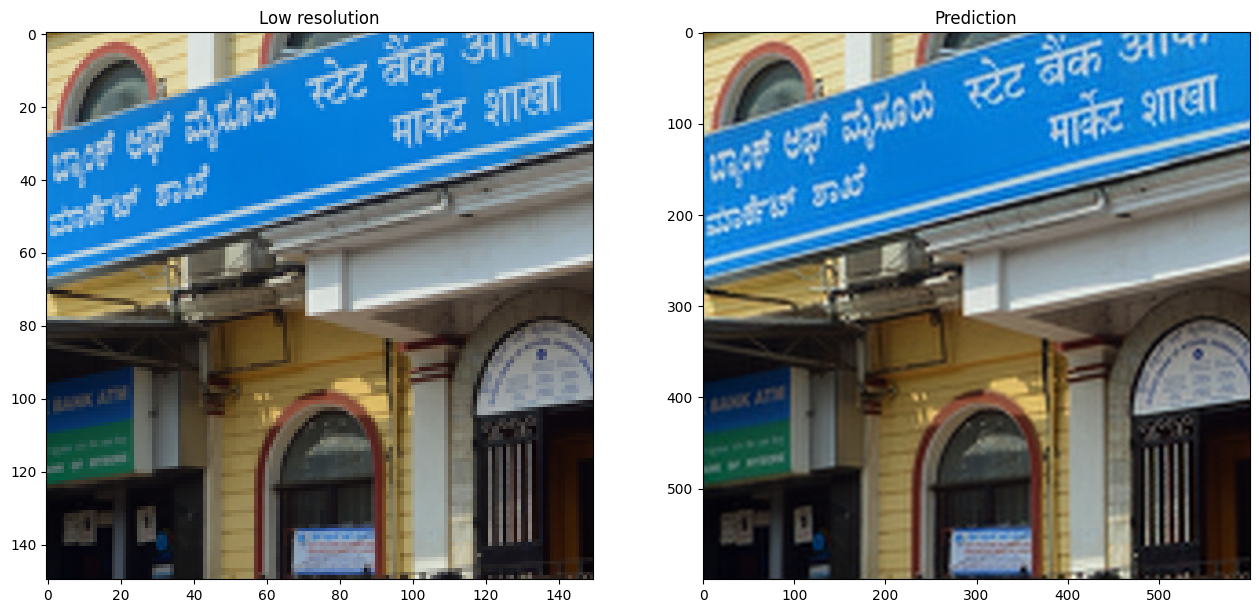

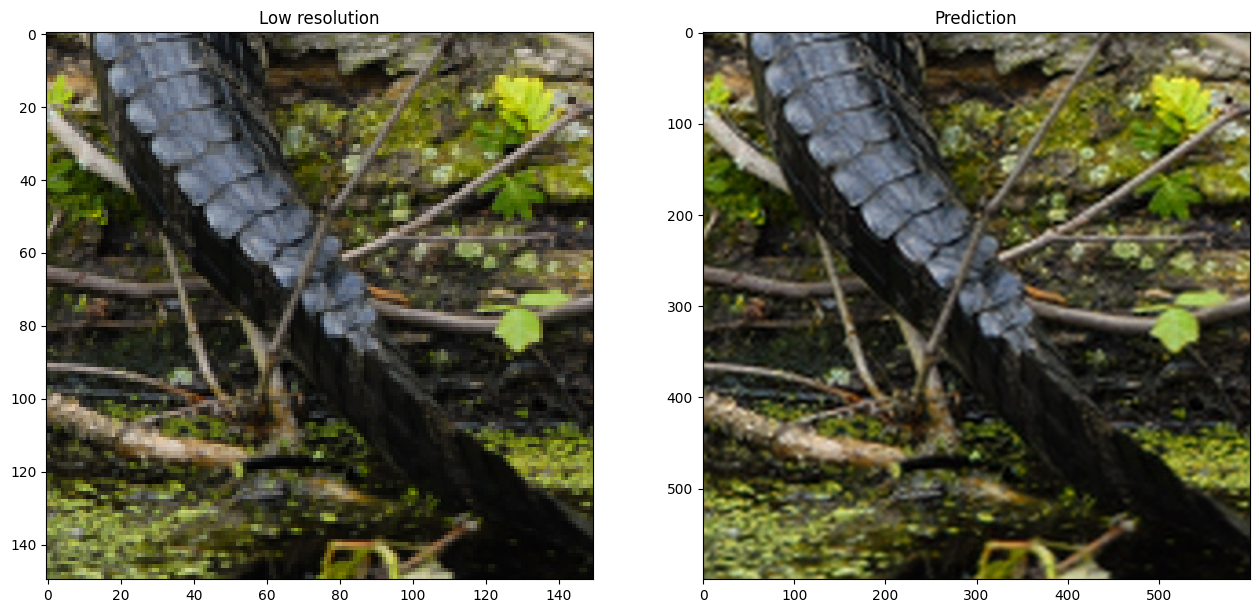

In [19]:
def plot_results(lowres_img,prediction):
  plt.figure(figsize=(24,14))
  plt.subplot(132), plt.imshow(lowres_img), plt.title('Low resolution')
  plt.subplot(133), plt.imshow(prediction), plt.title('Prediction')
  plt.show()

for lowres,highres in val.take(2):
  lowres = tf.image.random_crop(lowres,(150,150,3))
  prediction = model.predict_step(lowres)
  plot_results(lowres,prediction)


In [20]:
models = keras.models.load_model('/content/edsr_model.keras')